In [1]:
!conda install --yes --file requirements.txt

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.0
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# Smart Factory Energy Prediction Challenge

## Goals:
- Analyze the provided sensor data to identify patterns and relationships between environmental factors and equipment energy consumption
- Build a robust regression model to predict equipment energy consumption
- Evaluate the model's performance using appropriate metrics
- Provide actionable insights and recommendations for reducing energy consumption

In [2]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

## Data Preprocessing
### Importing the Datasets

In [3]:
df= pd.read_csv("./data/data.csv", parse_dates=['timestamp'])

### Handling missing data

In [4]:
print(df.isna().sum())

timestamp                         0
equipment_energy_consumption    844
lighting_energy                 809
zone1_temperature               867
zone1_humidity                  801
zone2_temperature               853
zone2_humidity                  867
zone3_temperature               802
zone3_humidity                  878
zone4_temperature               816
zone4_humidity                  781
zone5_temperature               838
zone5_humidity                  801
zone6_temperature               848
zone6_humidity                  847
zone7_temperature               794
zone7_humidity                  805
zone8_temperature               848
zone8_humidity                  777
zone9_temperature               773
zone9_humidity                  888
outdoor_temperature             806
atmospheric_pressure            842
outdoor_humidity                799
wind_speed                      828
visibility_index                815
dew_point                       826
random_variable1            

#### Data Types

**Time-Series**
- timestamp

**Numeric**
- timestamp
- equipment_energy_consumption
- lighting_energy
- zone1_temperature
- zone1_humidity
- zone2_temperature
- zone2_humidity
- zone3_temperature
- zone3_humidity
- zone4_temperature
- zone4_humidity
- zone5_temperature
- zone5_humidity
- zone6_temperature
- zone6_humidity
- zone7_temperature
- zone7_humidity
- zone8_temperature
- zone8_humidity
- zone9_temperature
- zone9_humidity
- outdoor_temperature
- atmospheric_pressure
- outdoor_humidity
- wind_speed
- visibility_index
- dew_point
- random_variable1
- random_variable2

Since there are no missing values for timestamp filling other columns. Using mean for other numeric data

In [5]:
def verify_df_missing(df, msg):
    print(msg)
    print(df.isna().sum())

In [6]:
def fillna(df):
    # timestamp is sorted first for proper forward-filling
    df.sort_values('timestamp', inplace=True)
    # Fill all other numeric columns with their mean
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [7]:
# Verify results
fillna(df)
verify_df_missing(df, "Missing values after treatment:")

Missing values after treatment:
timestamp                         0
equipment_energy_consumption    844
lighting_energy                 809
zone1_temperature               867
zone1_humidity                  801
zone2_temperature               853
zone2_humidity                    0
zone3_temperature                 0
zone3_humidity                    0
zone4_temperature                 0
zone4_humidity                    0
zone5_temperature                 0
zone5_humidity                    0
zone6_temperature                 0
zone6_humidity                    0
zone7_temperature                 0
zone7_humidity                    0
zone8_temperature                 0
zone8_humidity                    0
zone9_temperature                 0
zone9_humidity                    0
outdoor_temperature               0
atmospheric_pressure              0
outdoor_humidity                  0
wind_speed                        0
visibility_index                  0
dew_point                       

In [8]:
num_cols = ['equipment_energy_consumption', 'lighting_energy', 'zone1_temperature', 'zone1_humidity', 'zone2_temperature']

def column_converter(df: pd.DataFrame):
    for col in num_cols:
        if col in df.columns:  # Check if column exists
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Warning: Column {col} not found in DataFrame")

column_converter(df)
fillna(df)
verify_df_missing(df, "Missing values after treatment:")

Missing values after treatment:
timestamp                       0
equipment_energy_consumption    0
lighting_energy                 0
zone1_temperature               0
zone1_humidity                  0
zone2_temperature               0
zone2_humidity                  0
zone3_temperature               0
zone3_humidity                  0
zone4_temperature               0
zone4_humidity                  0
zone5_temperature               0
zone5_humidity                  0
zone6_temperature               0
zone6_humidity                  0
zone7_temperature               0
zone7_humidity                  0
zone8_temperature               0
zone8_humidity                  0
zone9_temperature               0
zone9_humidity                  0
outdoor_temperature             0
atmospheric_pressure            0
outdoor_humidity                0
wind_speed                      0
visibility_index                0
dew_point                       0
random_variable1                0
random_variable2

In [9]:
# extract time components
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Create temperature differential features
for zone in range(1, 10):
    df[f'zone{zone}_temp_diff'] = df[f'zone{zone}_temperature'] - df['outdoor_temperature']

# Calculate average zone temperature and humidity
df['avg_zone_temp'] = df[[f'zone{i}_temperature' for i in range(1, 10)]].mean(axis=1)
df['avg_zone_humidity'] = df[[f'zone{i}_humidity' for i in range(1, 10)]].mean(axis=1)

### Data Description

In [10]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 16857 entries, 0 to 16856
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  16857 non-null  float64       
 2   lighting_energy               16857 non-null  float64       
 3   zone1_temperature             16857 non-null  float64       
 4   zone1_humidity                16857 non-null  float64       
 5   zone2_temperature             16857 non-null  float64       
 6   zone2_humidity                16857 non-null  float64       
 7   zone3_temperature             16857 non-null  float64       
 8   zone3_humidity                16857 non-null  float64       
 9   zone4_temperature             16857 non-null  float64       
 10  zone4_humidity                16857 non-null  float64       
 11  zone5_temperature             168

Data description shows impossible values in equipment_energy_consumption i.e. negative values are present trying to use abosolute values.

In [11]:
negative_cols = ['equipment_energy_consumption', 'lighting_energy', 'zone1_humidity', 'zone2_humidity', 'zone3_humidity', 'zone4_humidity', 'zone5_humidity', 'zone6_humidity', 'zone7_humidity', 'zone8_humidity', 'zone9_humidity']
for col in negative_cols:
    df[col] = df[col].abs()

## Exploratory Data Analysis

In [12]:
cm = sns.light_palette("green", as_cmap=True)
df.head(30).style.background_gradient(cmap=cm)

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2,hour,day_of_week,month,zone1_temp_diff,zone2_temp_diff,zone3_temp_diff,zone4_temp_diff,zone5_temp_diff,zone6_temp_diff,zone7_temp_diff,zone8_temp_diff,zone9_temp_diff,avg_zone_temp,avg_zone_humidity
0,2016-01-11 17:00:00,60.000000,77.787786,33.746609,47.596667,19.200000,44.790000,19.790000,38.201314,19.000000,45.566667,17.166667,55.200000,6.469934,84.256667,17.200000,41.626667,18.200000,48.900000,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,17,0,1,27.146609,12.600000,13.190000,12.400000,10.566667,-0.130066,10.600000,11.600000,10.433333,18.645171,50.185331
1,2016-01-11 17:10:00,60.000000,30.000000,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,34.032621,18.200000,48.863333,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,17,0,1,13.406667,12.716667,13.306667,12.516667,10.683333,0.350000,10.716667,11.716667,10.583333,17.149630,49.990847
2,2016-01-11 17:20:00,50.000000,30.000000,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,35.921144,45.890000,19.052613,55.090000,6.560000,83.156667,17.200000,41.433333,18.200000,48.730000,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,17,0,1,13.523333,12.833333,13.423333,29.554477,12.685946,0.193333,10.833333,11.833333,10.633333,19.201528,50.628889
3,2016-01-11 17:30:00,50.000000,40.000000,33.746609,46.066667,19.200000,44.590000,19.790000,45.000000,20.239922,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.100000,94.385668,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,37.673716,45.410389,45.410389,17,0,1,27.496609,12.950000,13.540000,13.989922,10.916667,0.183333,10.883333,11.850000,10.750000,18.756652,55.663222
4,2016-01-11 17:40:00,60.000000,40.000000,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.100000,48.590000,4.476511,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,17,0,1,13.756667,13.066667,13.656667,12.756667,11.066667,0.233333,11.066667,11.966667,-1.656822,15.679242,50.732963
5,2016-01-11 17:50:00,50.000000,40.000000,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,45.730000,19.052613,55.030000,6.300000,85.766667,17.133333,41.260000,18.100000,48.590000,17.000000,40.318199,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,25.093780,17,0,1,13.873333,13.183333,13.773333,12.873333,13.035946,0.283333,11.116667,12.083333,10.983333,17.261772,50.239430
6,2016-01-11 18:00:00,60.000000,50.000000,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,35.921144,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,38.626835,48.590000,17.000000,40.318199,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763,18,0,1,13.990000,13.300000,13.890000,30.021144,11.200000,0.363333,11.233333,32.726835,11.100000,21.213849,50.235726
7,2016-01-11 18:10:00,60.000000,50.000000,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,45.863333,17.100000,54.900000,6.190000,86.423333,17.100000,41.200000,18.100000,48.590000,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,18,0,1,13.940000,13.283333,13.813333,12.973333,11.183333,0.273333,11.183333,12.183333,11.083333,17.018519,50.8029

### Graph 1 - Time Series Plot: Equipment Energy Over Time

- Trends: Long-term increases/decreases in energy usage (e.g., seasonal patterns)
- Cyclical Patterns: Daily/weekly operational cycles visible as repeating peaks and valleys
- Anomalies: Sudden spikes or drops that may indicate equipment issues or measurement errors
- Data Gaps: Missing time periods appear as breaks in the line

Key Questions It Answers:

Are there periods of unusually high/low consumption?

Does energy usage follow predictable patterns over time?

In [13]:
def energy_consumption_eda(df, timestamp_col='timestamp', energy_col='equipment_energy_consumption'):
 
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Time Series Plot
    def plot_time_series():
        plt.figure(figsize=(15, 6))
        df.set_index(timestamp_col)[energy_col].plot(color='steelblue', linewidth=1)
        plt.title(f'{energy_col.replace("_", " ").title()} Over Time', pad=20)
        plt.ylabel('Energy (Wh)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Correlation Analysis
    def plot_correlation():
        plt.figure(figsize=(10, len(df.columns)//2))  # Dynamic height
        corr_matrix = df.corr(numeric_only=True)
        sns.heatmap(corr_matrix[[energy_col]].sort_values(
            by=energy_col, ascending=False), 
            annot=True, cmap='coolwarm', center=0,
            annot_kws={'size': 9}, cbar_kws={'shrink': 0.8})
        plt.title(f'Correlation with {energy_col.replace("_", " ").title()}', pad=20)
        plt.tight_layout()
        plt.show()
    
    plot_time_series()
    plot_correlation()

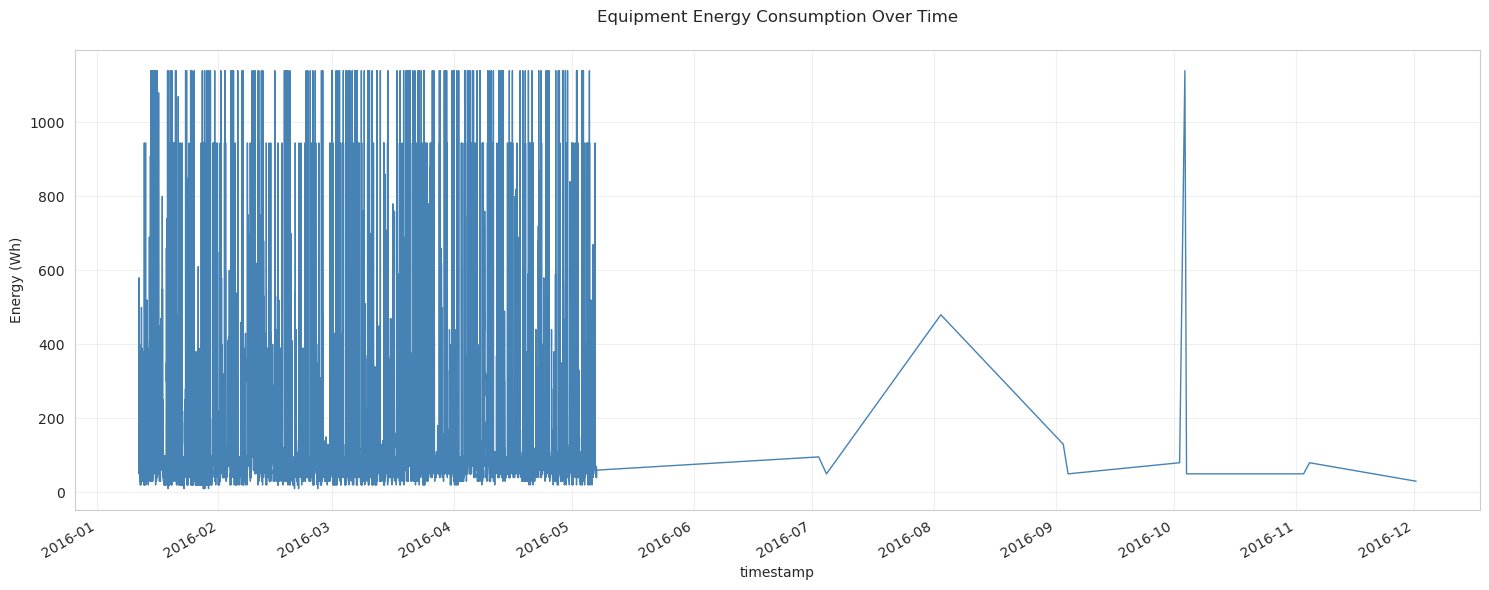

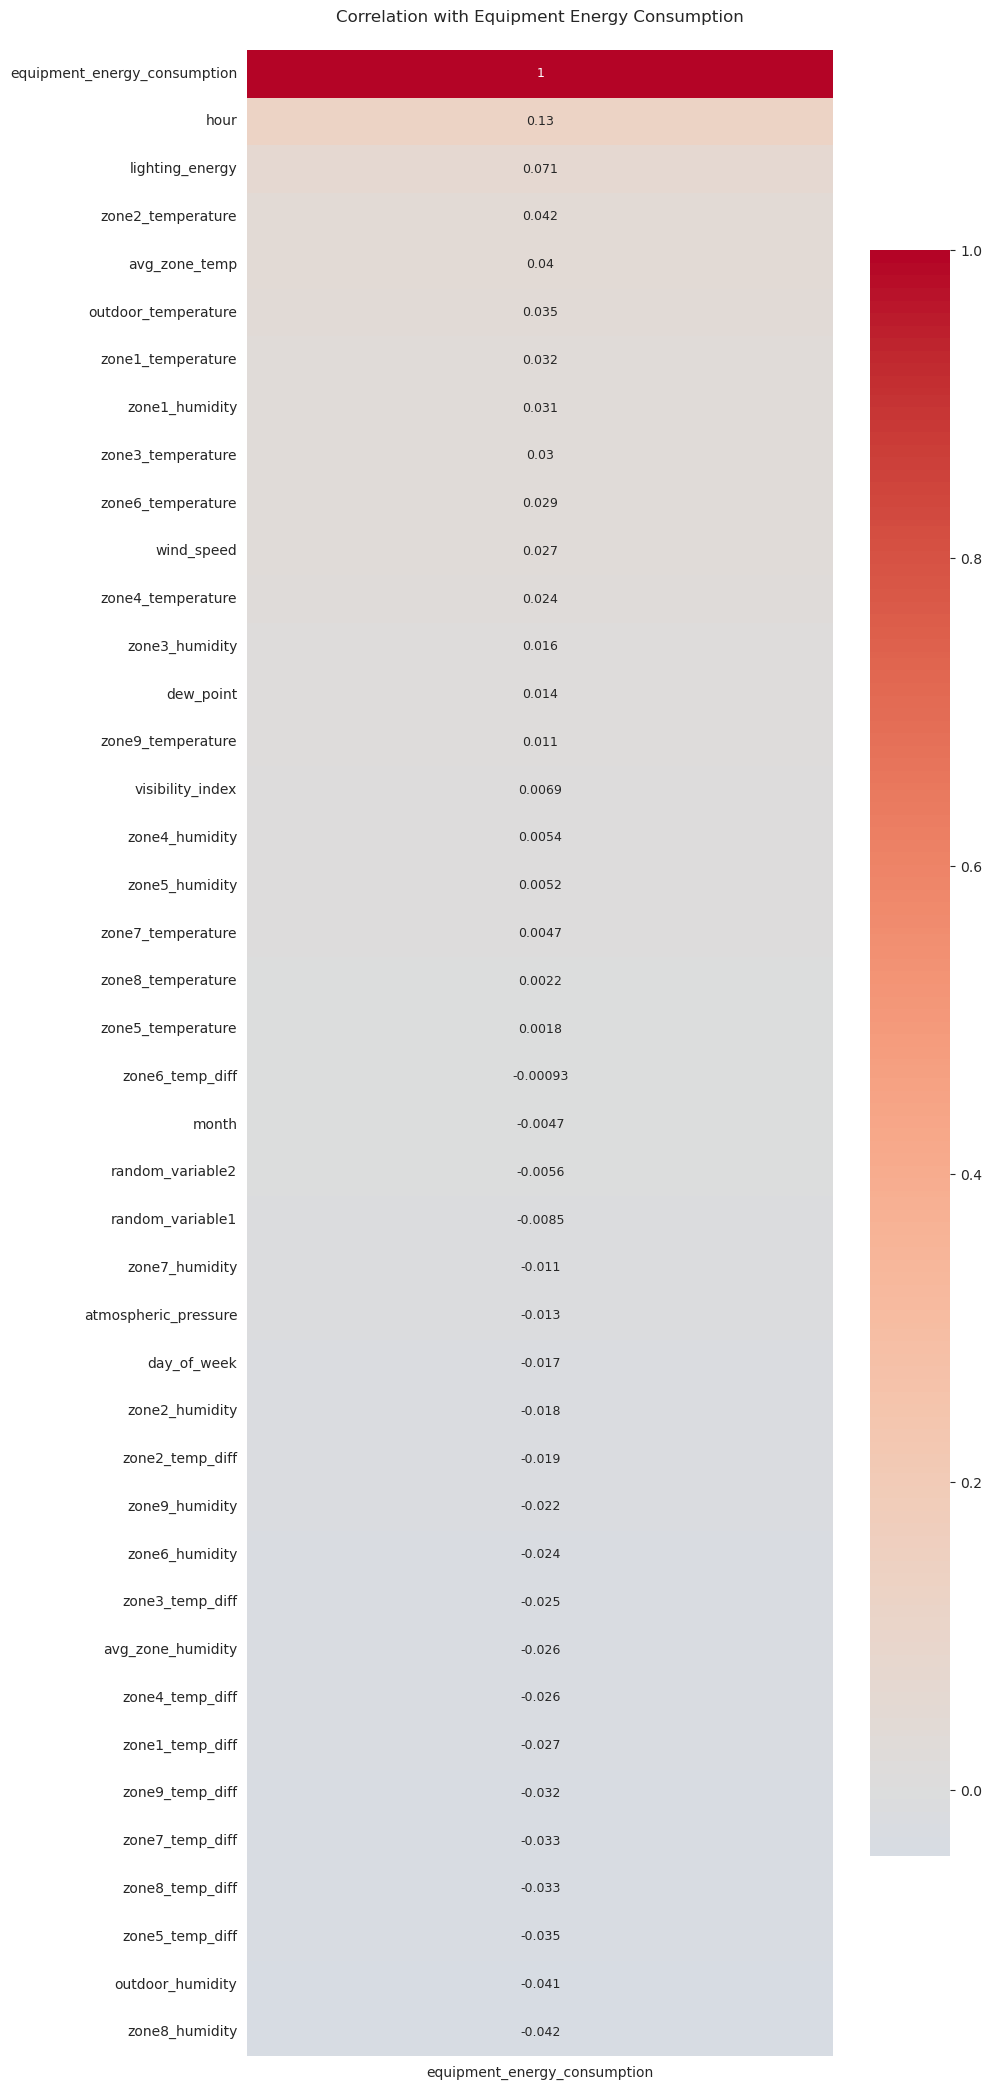

In [14]:
energy_consumption_eda(df)

### Graph 1

Shows heavy consumption on from midday 2-16 to midday 5-16.

### Graph 2

The correlation graph indicates which features should be used.

## Feature Selection

The purpose of the model is to predict the energy consumption using environmental factors. Thus taking column 'equipment_energy_consumption' as dependent vector y. Excluding lighting_energy as it is a different dependent vector.

In [15]:
# dp_cols = ['month', 'hour', 'day_of_week', 'lighting_energy', 'random_variable1', 'random_variable2']
# dp_cols = ['lighting_energy', 'visibility_index', 'zone4_humidity', 'zone5_humidity', 'zone7_temperature', 'zone8_temperature', 'zone5_temperature', 'zone6_temp_diff', 'month', 'random_variable1', 'random_variable2']
dp_cols = ['lighting_energy']
df = df.drop(columns=dp_cols).reset_index(drop=True)

In [16]:
y = df['equipment_energy_consumption']
X = df.drop(columns=['equipment_energy_consumption'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define time feature extractor
def extract_time_features(X):
    df = pd.DataFrame(X, columns=['timestamp'])
    return np.column_stack([
        df['timestamp'].dt.hour,
        df['timestamp'].dt.dayofweek,
        df['timestamp'].dt.month
    ])

## Model Building

k = 15

Model        RMSE        R²
3      RandomForest  162.769622  0.073747
2      DecisionTree  165.966089  0.037010
0  LinearRegression  167.876149  0.014717
1               KNN  171.314964 -0.026062

Best model: RandomForest

k = 30

Model        RMSE        R²
3      RandomForest  161.609187  0.086907
2      DecisionTree  166.718831  0.028255
0  LinearRegression  167.951639  0.013831
1               KNN  170.370777 -0.014783

Best model: RandomForest

k= 20
Model        RMSE        R²
3      RandomForest  161.931802  0.083258
2      DecisionTree  165.929212  0.037438
0  LinearRegression  167.912330  0.014292
1               KNN  170.302471 -0.013970

Best model: RandomForest

In [19]:
preprocessor = ColumnTransformer([
    ('time_features', FunctionTransformer(extract_time_features), ['timestamp']),
    ('numeric', 'passthrough', X_train.select_dtypes(include=['number']).columns)
])
k = 15

models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_regression, k=k)),
        ('model', LinearRegression())
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_regression, k=k)),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_regression, k=k)),
        ('model', DecisionTreeRegressor(max_depth=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_regression, k=k)),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

In [20]:
results = []
for name, pipeline in models.items():
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R²': r2
    })

# 5. Results Comparison
results_df = pd.DataFrame(results).sort_values('RMSE')
print(results_df)

# 6. Best model inspection
best_model = models[results_df.iloc[0]['Model']]
print("\nBest model:", results_df.iloc[0]['Model'])

              Model        RMSE        R²
3      RandomForest  162.769622  0.073747
2      DecisionTree  165.966089  0.037010
0  LinearRegression  167.876149  0.014717
1               KNN  171.314964 -0.026062

Best model: RandomForest


/tmp/ipykernel_17133/2685068448.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='RMSE', y='Model', data=results_df, palette="viridis")


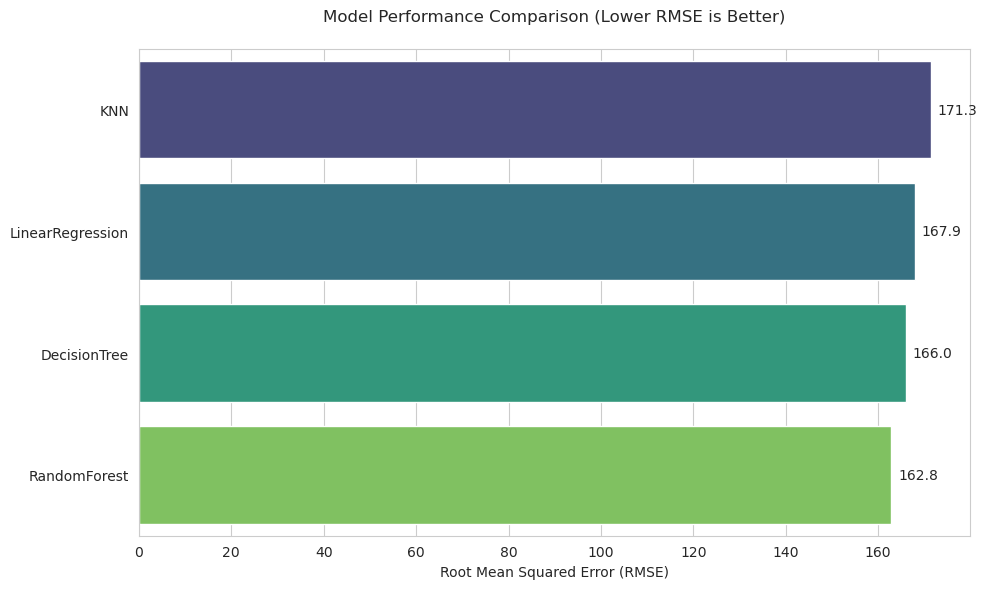

In [21]:
results_df = results_df.sort_values('RMSE', ascending=False)

# Create figure
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Bar plot for RMSE
ax = sns.barplot(x='RMSE', y='Model', data=results_df, palette="viridis")
plt.title('Model Performance Comparison (Lower RMSE is Better)', pad=20)
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('')

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_width():.1f}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

## Visualization

results_df = results_df.sort_values('RMSE', ascending=False)

# Create figure
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Bar plot for RMSE
ax = sns.barplot(x='RMSE', y='Model', data=results_df, palette="viridis")
plt.title('Model Performance Comparison (Lower RMSE is Better)', pad=20)
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('')

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_width():.1f}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

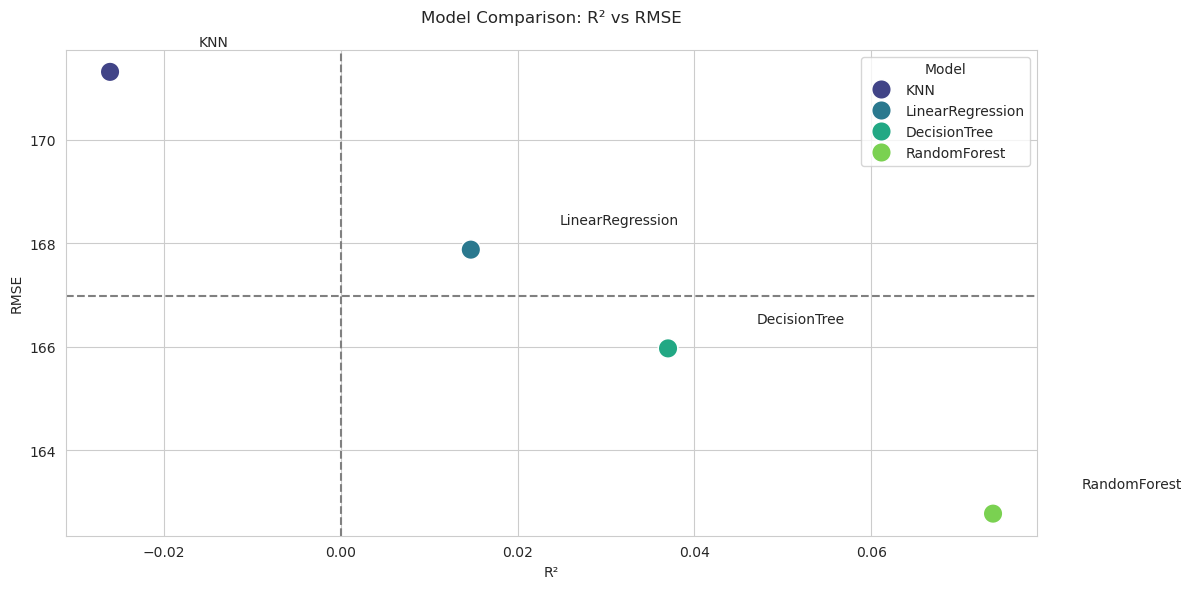

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='R²', y='RMSE', hue='Model', 
                data=results_df, s=200, palette="viridis")

plt.title('Model Comparison: R² vs RMSE', pad=20)
plt.axvline(x=0, color='grey', linestyle='--')
plt.axhline(y=results_df['RMSE'].mean(), color='grey', linestyle='--')

# Annotate points
for i, row in results_df.iterrows():
    plt.text(x=row['R²']+0.01, y=row['RMSE']+0.5, 
             s=row['Model'], fontsize=10)

plt.tight_layout()
plt.show()